In [1]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

X = pkl.load(open('/data/SPRINT/X_processed.pkl', 'rb'))
y = pkl.load(open('/data/SPRINT/y_processed.pkl', 'rb'))

print(X.shape, y.shape)

((6502, 3, 12), (6502,))


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

training_size = 6000

X_train = X[:training_size]
y_train = y[:training_size]

X_test = X[training_size:]
y_test = y[training_size:]

X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

classifier = RandomForestClassifier()
y_pred = classifier.fit(X_train, y_train).predict(X_test)

accuracy_score(y_test, y_pred)

0.94223107569721121

In [3]:
noise = np.random.normal(0, 1, 600)
plt.hist(noise, bins=30)
print(np.where(abs(noise)<0.01))

(array([59]),)


In [4]:
#directory = './output/2.0_0.001_200_0.002_100/'
#directory = './output/4.0_0.0001_500_0.002_100/'
directory = '/data/SPRINT/nonprivate/'

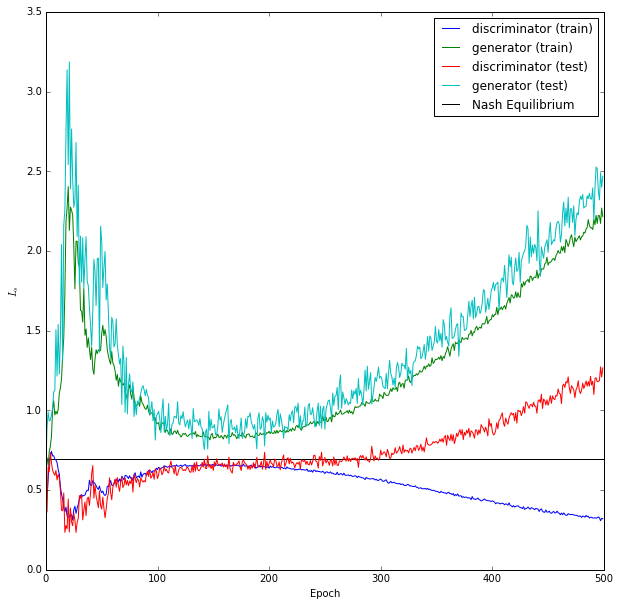

In [5]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
plt.figure(figsize=(10,10))

hist = pkl.load(open(directory + 'acgan-history.pkl', 'rb'))
losses = ['loss', 'generation_loss', 'auxiliary_loss']

for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=losses)

for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        plt.plot(hist[p][g]['generation_loss'], label='{} ({})'.format(g, p))

# get the NE and show as an equilibrium point
plt.hlines(-np.log(0.5), 0, hist[p][g]['generation_loss'].shape[0], label='Nash Equilibrium')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel(r'$L_s$')

plt.show()

# for p in hist['privacy']:
#     print(p)

# Transfer Learning

In [7]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

acgan = __import__('ac_gan')

from glob import glob
from keras.models import load_model
from sklearn import linear_model

latent_size = 100


lr_clf = linear_model.LogisticRegression()
transfer_clf = RandomForestClassifier()

mean_scores = []
lr_scores = []
#directory = './output/p' + str(9) + '_8.0_0.0001_500_0.002_100/'
# directory = './output/acgan_500_0.0002_100/'

for i in range(0, 500):
    gen_name = sorted(glob(directory + 'params_generator*'))[i]
    print(gen_name)
    g = load_model(gen_name)

    generate_count = training_size

    noise = np.random.uniform(-1, 1, (generate_count, latent_size))
    sampled_labels = np.random.randint(0, 2, generate_count)
    generated_images = g.predict([noise, sampled_labels.reshape((-1, 1))], verbose=0)

    gen_X_train = np.reshape(generated_images, (training_size, 3, 12))
    gen_X_train = gen_X_train.astype(int)
    gen_X_train = gen_X_train.clip(min=0)

    gen_X_train = gen_X_train.reshape(generate_count, -1)
    gen_y_train = sampled_labels


    mean_scores.append(accuracy_score(y_train, transfer_clf.fit(gen_X_train, gen_y_train).predict(X_train)))
    lr_scores.append(accuracy_score(y_train, lr_clf.fit(gen_X_train, gen_y_train).predict(X_train)))
pkl.dump({'rf': mean_scores, 'lr': lr_scores}, open(directory + 'train_epoch_scores.p', 'wb'))

/data/SPRINT/nonprivate/params_generator_epoch_000.h5
/data/SPRINT/nonprivate/params_generator_epoch_001.h5
/data/SPRINT/nonprivate/params_generator_epoch_002.h5
/data/SPRINT/nonprivate/params_generator_epoch_003.h5
/data/SPRINT/nonprivate/params_generator_epoch_004.h5
/data/SPRINT/nonprivate/params_generator_epoch_005.h5
/data/SPRINT/nonprivate/params_generator_epoch_006.h5
/data/SPRINT/nonprivate/params_generator_epoch_007.h5
/data/SPRINT/nonprivate/params_generator_epoch_008.h5
/data/SPRINT/nonprivate/params_generator_epoch_009.h5
/data/SPRINT/nonprivate/params_generator_epoch_010.h5
/data/SPRINT/nonprivate/params_generator_epoch_011.h5
/data/SPRINT/nonprivate/params_generator_epoch_012.h5
/data/SPRINT/nonprivate/params_generator_epoch_013.h5
/data/SPRINT/nonprivate/params_generator_epoch_014.h5
/data/SPRINT/nonprivate/params_generator_epoch_015.h5
/data/SPRINT/nonprivate/params_generator_epoch_016.h5
/data/SPRINT/nonprivate/params_generator_epoch_017.h5
/data/SPRINT/nonprivate/para

Using TensorFlow backend.


# PCA plot

(1000, 36)


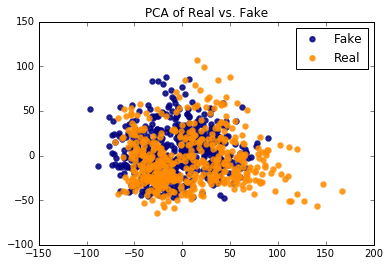

In [20]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

plot_count = 500
X_pca = np.concatenate((gen_X_train[:plot_count], X_train[:plot_count]))
print(X_pca.shape)

y = np.array([1] * plot_count + [0] * plot_count)

pca = PCA(n_components=2)
X_r = pca.fit(X_pca).transform(X_pca)

target_names = ['Fake', 'Real']
colors = ['navy', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.title('PCA of Real vs. Fake')